# Forecasting vegetation condition 

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background

This notebook conducts timeseries forecasting of vegetation condition (NDVI) using [autoregression](https://en.wikipedia.org/wiki/Autoregressive_model).

## Description

In this notebook, we generate a NDVI timeseries from Sentinel-2, then use it develop a forecasting algorithm.

The following steps are taken:

1. Load Sentinel-2 data and calculate NDVI.
2. Test for stationarity.
3. Conduct a cross-validation forecast and inspect results to check forecast performance.
4. Forecast NDVI into the future.

***

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import datacube
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datacube import Datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.load_era5 import load_era5

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37991 Dashboard: /user/mickwelli/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="NDVI_forecast")

## Analysis parameters

* `lat`, `lon`: The central latitude and longitude to analyse. In this example we'll used grasslands in the Serengeti.
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower
* `time_range`: The date range to analyse.
* `freq`: The frequency we want to resample the timeseries to e.g. for monthly time steps use `'1M'`, for fortinightly use `'2W'`
* `dask_chunks`: How to chunk the datasets to work with dask

In [4]:
# Define the analysis region (Lat-Lon box)
lat, lon = -1.4908, 34.7683 # grasslands in serengeti
buffer = 0.02

products = "s2_l2a"

# Define the time window
time_range = ('2017-01-01', '2021-12-31')

#resample frequency
freq='2W'

#dask chunk sizes
dask_chunks={'x':-1, 'y':-1, 'time':-1}

## Display analysis area on an interactive map

In [5]:
lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

display_map(lon,lat)

### Load the satellite data

In [6]:
# set up a datcube query object
query = {'x': lon, 'y': lat,
         'time': time_range,
         'measurements':['red', 'nir'],
         'output_crs' :'EPSG:6933',
         'resolution' : (-10, 10),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

In [7]:
# load the satellite data
ds = load_ard(dc=dc, 
              dask_chunks=dask_chunks,
              products=products,
              **query)
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 343 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 343, y: 511, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2021-12-27T08:...
  * y            (y) float64 -1.876e+05 -1.876e+05 ... -1.927e+05 -1.927e+05
  * x            (x) float64 3.353e+06 3.353e+06 ... 3.357e+06 3.357e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(343, 511, 387), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(343, 511, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


#### Calculate NDVI timeseries

The satellite data will be computed to NDVI and resampled to a fortnightly timeseries here. The interpolation cell can take a little while to run.

In [8]:
# calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='s2')

Dropping bands ['red', 'nir']


In [9]:
# interpolate NDVI to a fortnightly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time=freq).mean()
ndvi = ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

#### Smooth the timeseries

We will use a rolling average of 5 observations to smooth the timeseries. This can remove some extremes and improve forecast skill.

In [10]:
# smooth the timeseries using a rolling average
ndvi_df = ndvi.to_dataframe()
ndvi_df['ndvi_smooth'] = ndvi_df['NDVI'].rolling(5).mean()
ndvi_df = ndvi_df.dropna()

#### Plot the NDVI timeseries

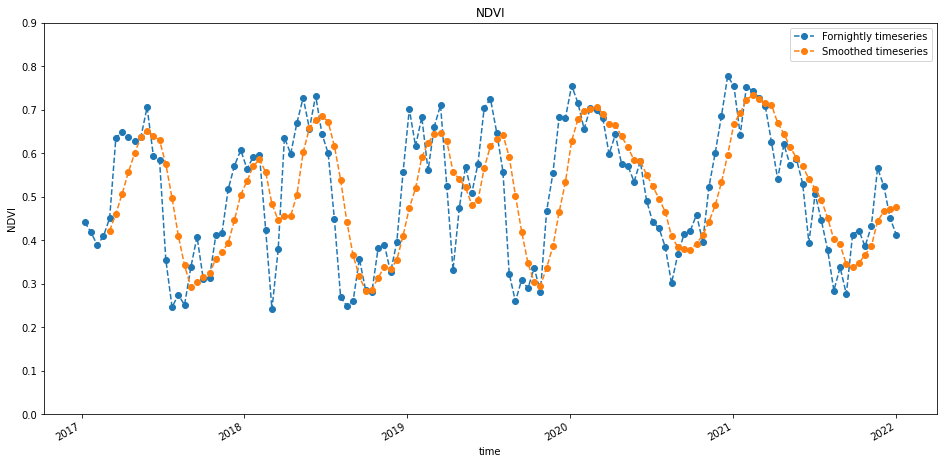

In [11]:
ndvi.plot(figsize=(16,8),linestyle='dashed', marker='o', label = "Fornightly timeseries")
ndvi_df.ndvi_smooth.plot(figsize=(16,8),linestyle='dashed', marker='o', label = "Smoothed timeseries")
plt.title('NDVI')
plt.legend(loc="upper right")
plt.ylim(0,0.9);

## Test for stationarity 

AR models require the time series you want to forecast to be stationary. A stationary time series is one whose characteristics like mean and variance does not change over time. 
To test the stationarity, we can use a method called the [Augmented Dickey-Fuller Test (ADF Test)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/).

If the timeseries are non-stationary, you can make it stationary by differencing the series once and repeating the test again until it becomes stationary. Differencing can be done easily using the following code snippet:

    df_differenced = df_train.diff().dropna()

Define a function for conducting an ADF test

In [12]:
r = adfuller(ndvi_df.ndvi_smooth, autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
print(f'    ADF Test on NDVI', "\n   ", '-'*47)
print(f' Null Hypothesis: Data is non-Stationary.')
    
if p_value <= 0.05:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
else:
        print(f" => P-Value = {p_value}. Should not reject the Null Hypothesis")
        print(f" => Series is Non-Stationary.")    

    ADF Test on NDVI 
    -----------------------------------------------
 Null Hypothesis: Data is non-Stationary.
 => P-Value = 0.0013. Rejecting Null Hypothesis.
 => Series is Stationary.


### Select a lag order (p)

The lag order (p) is an important term in autoregression forecasting. It refers to the maximum numbers of past terms to be tested for correlation. We can inspect an autcorrelation plot to pick a lag order value, or we can automate it. 

Autocorrelation is the correlation of a value at a given time-step to values at lagged intervals. The autocorrelation for lag order 0 is 1 (see below) because it is the correlation between each term and itself. The autocorrelation tends to decline as lag order increases.

The plot below shows autocorrelation on the y-axis and lag order on the x-axis. A lag order of 1 has the highest applicable autocorrelation, and 2 or 3 also look ok. 

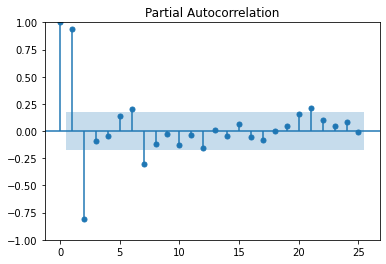

In [13]:
pacf = plot_pacf(ndvi_df.ndvi_smooth, lags=25, method='ywm', alpha=0.05)

We've selected a lag order of 2 here, although you can change this and investigate how it affects the accuracy of the model. We'll also automate lag order selection below.

In [14]:
lag_order = 2

## Split data and fit a model

### Split training and test data

Cross-validation is a common method for evaluating model performance. It involves dividing data into a training set on which the model is trained, and test (or validation) set, to which the model is applied to produce predictions which are compared against actual values (that weren't used in model training).

In [ ]:
train_data = ndvi_df['ndvi_smooth'][:len(ndvi_df)-10] # remove the last ten observations and keep them as test data
test_data = ndvi_df['ndvi_smooth'][len(ndvi_df)-10:]

### Fit model to training data

In [ ]:
model=AutoReg(train_data, lags=lag_order).fit()
print(model.summary())

### Fit model with automated lag order selection

What lag order is chosen? How does the model summary compare with the model summary above?

In [ ]:
sel = ar_select_order(train_data, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

### Check the model on test data

We saved the last 10 observations as test data above. Now we can use our model to predict NDVI for those time-steps and compare those predictions with actual values. We can do this visually in the graph below and also quantify the error with the root-mean-square error (RMSE).

In [ ]:
pred = res.predict(start=len(train_data), end=(len(ndvi_df)-1), dynamic=False) # use 'res' for auto lag order selection or 'model' for user selected

plt.figure(figsize=(11,5))
pred.plot(label='forecast')
train_data.plot(label='training data')
test_data.plot(label='test data')
plt.legend(loc="upper right");

### Check RMSE on test data

The root-mean-square error (RMSE) is a common metric used to evaluate model or forecast performance. It is the standard deviation of residuals (difference between forecast and actual value) expressed in units of the variable of interest e.g. NDVI.

In [ ]:
print('rmse value for NDVI is : ', round(rmse(pred, test_data),2))

### Plot model diagnostics

There are some typical plots we can use to evaluate our model. 

1. **Standardised residuals:**
    The standardised residuals are plotted against x (time) values. This allows us to check that variance (distance of residuals from 0) is constant across time values. There should be no obvious patterns.
    
2. **Histogram and estimated density:**
    A kernel density estimation (KDE) is an estimated probability density function fitted on the actual distribution (histogram) of standardised residuals. A normal distribution (N (0,1)) is shown for reference. This plot shows that the distribution of our standardised residuals is close to normally distributed.
    
3. **Normal quantile-quantile (Q-Q) plot:**
     This plot shows 'expected' or 'theoretical' quantiles drawn from a normal distribution on the x-axis against quantiles taken from the sample of residuals on the y-axis. If the observations in blue match the 1:1 line in red, then we can conclude that our residuals are normally distributed.
     
4. **Correlogram:**
    The correlations for lags greater than 0 should not be statistically significant. That is, they should not be outside the blue ribbon.
    

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = model.plot_diagnostics(lags=25, fig=fig)

## Plot the result of our forecast

Our model looks good in the diagnostic plots above, so we will use it to forecast NDVI into the future. 

This time, we'll run a model on the entire time series so we can include the latest observations.

In [ ]:
sel = ar_select_order(ndvi_df['ndvi_smooth'], 13, old_names=False)
sel.ar_lags
res = sel.model.fit()

fig = res.plot_predict('2021-01-31','2022-07-01', figsize=(18,6));

Our forecast looks reasonable in the context of the timeseries above. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2022

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')